### 1. 로지스틱 회귀 2. knn  3. SVM

In [28]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [29]:
df = pd.DataFrame({
    "customer":  [f"고객{i}" for i in range(1, 13)],
    "sales":     [100, 120, 130, 140, 150, 200, 220, 180, 190, 200, 210, 120],
    "income":    [10, 12, 13, 14, 15, 16, 17, 20, 22, 19, 20, 22],
    "interest":  [1.2, 1.5, 1.4, 1.3, 1.4, 1.5, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5],
    "loans": [100, 105, 102, 103, 104, 104, 105, 105, 103, 102, 104, 105],
    "status": [
        "정상", "정상", "연체", "정상", "정상", "정상",
        "정상", "정상", "정상", "정상", "연체", "연체"
    ]
})

df

,customer,sales,income,interest,loans,status
0,고객1,100,10,1.2,100,정상
1,고객2,120,12,1.5,105,정상
2,고객3,130,13,1.4,102,연체
3,고객4,140,14,1.3,103,정상
4,고객5,150,15,1.4,104,정상
5,고객6,200,16,1.5,104,정상
6,고객7,220,17,1.4,105,정상
7,고객8,180,20,1.4,105,정상
8,고객9,190,22,1.4,103,정상
9,고객10,200,19,1.5,102,정상


#### # 타깃 인코딩: 정상=0, 연체=1

In [30]:
df["y"] = df["status"].map({"정상": 0, "연체": 1})

X = df[["sales", "income", "interest", "loans"]]
y = df["y"]


#### Train/Test 분할 (7:3) + 스케일링

In [4]:
# kNN/SVM은 스케일링 필수, 로지스틱도 함께 적용해 공정 비교

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


#### 모델 학습

In [32]:
# 1) 로지스틱 회귀
logit = LogisticRegression()
logit.fit(X_train_sc, y_train)

# 2) KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_sc, y_train)

# 3) SVM
svm = SVC(kernel="rbf", C=1.0, gamma="scale")
svm.fit(X_train_sc, y_train)


SVC()

#### 예측 & 혼동행렬 (표로 보기)

In [7]:
models = {
    "Logistic": logit,
    "KNN": knn,
    "SVM": svm
}

def cm_table(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(
        cm,
        index=["Actual 정상", "Actual 연체"],
        columns=["Pred 정상", "Pred 연체"]
    ).assign(Model=name)

tables = []
for name, model in models.items():
    y_pred = model.predict(X_test_sc)
    tables.append(cm_table(y_test, y_pred, name))

cm_results = pd.concat(tables)
cm_results


,Pred 정상,Pred 연체,Model
Actual 정상,3,0,Logistic
Actual 연체,1,0,Logistic
Actual 정상,3,0,KNN
Actual 연체,1,0,KNN
Actual 정상,3,0,SVM
Actual 연체,1,0,SVM


In [8]:
# 로지스틱: 해석 용이, 기준선 모델

# KNN: 거리 기반 → 스케일링 중요

# SVM: 비선형 경계 강점, 소표본에서도 강력

#### 각 모델의 정확도/정밀도/재현율/F1 비교표

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# 모델별 성능 지표 계산
# 양성 클래스(positive class) = 연체(1)
# → average="binary" 기본값 사용

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_sc)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    })

metrics_df = pd.DataFrame(results)
metrics_df


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic,0.75,0.0,0.0,0.0
1,KNN,0.75,0.0,0.0,0.0
2,SVM,0.75,0.0,0.0,0.0


In [10]:
# 지표 해석 가이드 (연체 예측 기준)
# 지표	의미	금융 해석
# Accuracy	전체 맞춘 비율	⚠️ 불균형 데이터에 취약
# Precision	연체로 예측한 것 중 진짜 연체	불필요한 차단 감소
# Recall	실제 연체 중 잡아낸 비율	⭐ 가장 중요
# F1-score	Precision·Recall 균형	종합 성능

### Iris 데이터셋 (이진 분류로 단순화)

- 통계·머신러닝에서 분류(classification) 예제로 널리 사용되는 데이터셋 
- 서로 다른 붓꽃(Iris) 3종을 꽃잎/꽃받침 길이·너비로 구분합니다.
- 데이터 구성
-총 샘플 수: 150개
-클래스(종): 3개
-Iris setosa
-Iris versicolor
-Iris virginica
-→ 각 클래스당 50개
- 입력 특성(Features, 4개)
- Sepal length (꽃받침 길이, cm), Sepal width (꽃받침 너비, cm), Petal length (꽃잎 길이, cm), Petal width (꽃잎 너비, cm)
- 정답 라벨(Label) : 붓꽃의 종(species)

- 데이터 분할 → 스케일링 → 학습 → 평가(정확도/혼동행렬/리포트) 

In [33]:
# scikit-learn에 내장된 Iris 데이터셋을 불러와서 입력(X)과 라벨(y)을 분리
# iris = load_iris() :  Iris 데이터셋을 객체 형태로 로드
# X = iris.data : # (150, 4) 🔹 의미 입력 특성(feature) 행렬: (샘플 수, 특성 수) = (150, 4)
# y = iris.target : 정답 라벨(label) 벡터

from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data      # (150, 4)
y = iris.target    # (150,)
target_names = iris.target_names

In [26]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 1) 데이터 생성 
# n_samples=500 : 생성할 데이터 샘플 수, 총 500개 관측치
# n_informative=3 : 클래스 구분에 실제로 중요한 특성 수
# n_redundant=1 :  informative feature의 선형 결합으로 만들어진 중복 특성


X, y = make_classification(
    n_samples=500,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_clusters_per_class=2,
    class_sep=0.8,
    flip_y=0.1,
    random_state=42
)

# 2) Train/Test 분할 (클래스 비율 유지: stratify)
# 입력 인자: X, ytrain_test_split(X, y, ...)X : 입력 특성 행렬 (features), y : 정답 라벨 벡터 (labels)
# random_state=42 : 난수 시드 고정, 매번 같은 방식으로 데이터 분할, 실험 재현성(reproducibility) 확보
# stratify=y (핵심) : stratify=y  의미 : 클래스 비율을 유지한 채 분할,  클래스 불균형 문제 완화

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3) 스케일링 (로지스틱 회귀는 스케일에 민감)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# 4) 모델 정의 & 학습
# solver='lbfgs'는 기본값 중 하나, 이진/다중분류 모두 무난
# max_iter는 수렴 안 할 때를 대비해 넉넉히
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# 5) 예측
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # 클래스 1일 확률(이진분류 기준)

# 6) 평가
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

auc = roc_auc_score(y_test, y_proba)

print("Accuracy:", acc)
print("ROC-AUC:", auc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

# 7) (선택) 특성 중요도(계수) 확인
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)


Accuracy: 0.82
ROC-AUC: 0.8699479791916767

Confusion Matrix:
 [[43  8]
 [10 39]]

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.84      0.83        51
           1       0.83      0.80      0.81        49

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

Coefficients: [[ 0.55933241  1.24057204  0.20987444  0.35812295 -0.15587267]]
Intercept: [0.04558503]


In [ ]:
- ROC = Receiver Operating Characteristic
- x축: FPR (False Positive Rate)
- y축: TPR (True Positive Rate, Recall)
- 정의 : 임계값(threshold)을 바꾸면서 (FPR, TPR) 점들을 연결한 곡선
- AUC란? : AUC = Area Under the ROC Curve , ROC 곡선 아래 면적. 값 범위: 0 ~ 1
- AUC = 임의의 양성 샘플이 임의의 음성 샘플보다 더 높은 점수를 받을 확률

In [ ]:
# 중요도 시각화

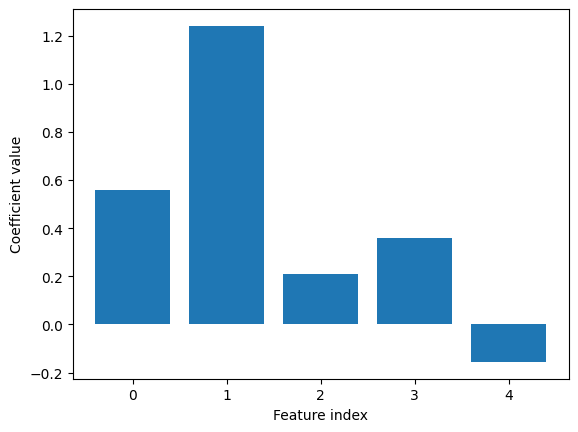

In [27]:
import matplotlib.pyplot as plt

plt.bar(range(5), model.coef_[0])
plt.xlabel("Feature index")
plt.ylabel("Coefficient value")
plt.show()


In [ ]:
- KNN / SVM

In [15]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

# 1) 데이터 생성 (동일)
X, y = make_classification(
    n_samples=500,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_clusters_per_class=2,
    class_sep=0.8,
    flip_y=0.1,
    random_state=42
)

# 2) Train/Test 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

def evaluate_model(name, model, X_test, y_test):
    """공통 평가 함수"""
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\n===== {name} =====")
    print("Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", report)

    # ROC-AUC: predict_proba가 있으면 그걸, 없으면 decision_function 사용
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_score)
        print("ROC-AUC:", auc)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_score)
        print("ROC-AUC:", auc)
    else:
        print("ROC-AUC: (score output이 없어 계산 생략)")

# -------------------------
# 3) KNN
# -------------------------
knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(
        n_neighbors=7,     # k 값(튜닝 대상)
        weights="distance" # 가까운 점에 더 큰 가중
    ))
])

knn.fit(X_train, y_train)
evaluate_model("KNN", knn, X_test, y_test)

# -------------------------
# 4) SVM
# -------------------------
# SVC는 기본적으로 확률을 안 뽑음 -> ROC-AUC 위해 probability=True 또는 decision_function 사용
svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",  # 비선형 분리 (기본적으로 강력)
        C=1.0,         # 규제 강도(클수록 과적합 쪽)
        gamma="scale", # RBF 폭(영향 범위)
        probability=True,  # predict_proba 가능(조금 느려짐)
        random_state=42
    ))
])

svm.fit(X_train, y_train)
evaluate_model("SVM (RBF)", svm, X_test, y_test)



===== KNN =====
Accuracy: 0.86
Confusion Matrix:
 [[43  8]
 [ 6 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.84      0.86        51
           1       0.84      0.88      0.86        49

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

ROC-AUC: 0.9125650260104041

===== SVM (RBF) =====
Accuracy: 0.88
Confusion Matrix:
 [[45  6]
 [ 6 43]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88        51
           1       0.88      0.88      0.88        49

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

ROC-AUC: 0.9475790316126451


### 로지스틱 회귀 / KNN / SVM  세 모델의 혼돈행렬을 각각 시각적

- 공통: 혼돈행렬 시각화 함수

In [ ]:
# cm = confusion_matrix(y_true, y_pred)
# 이진 분류라면:cm =[[TN, FP], [FN, TP]]
# → cm.shape == (2, 2)
# 즉, cm.shape[0] → 행(row) 개수 (True label)
# cm.shape[1] → 열(column) 개수 (Predicted label)
# 이중 for문 의미
# for i in range(cm.shape[0]):      # 행 인덱스
#     for j in range(cm.shape[1]):  # 열 인덱스
# 모든 셀(cell)을 하나씩 순회
# (i, j) = 혼돈행렬의 각 위치

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()

    # 혼돈행렬 그림 위에 숫자를 직접 써 넣는 핵심 코드
    for i in range(cm.shape[0]):     # 행 인덱스
        for j in range(cm.shape[1]):   # 열 인덱스
            plt.text(j, i, cm[i, j],   # 각 인자의 의미 j : x축 위치 (열 위치) , i ;y축 위치 (행 위치) text = cm[i, j]: 표시할 숫자
                     ha="center", va="center")  # ha="center: "horizontal alignment 텍스트를 셀의 가로 중앙에 배치
                                                # va="center" : vertical alignment 텍스트를 셀의 세로 중앙에 배치

    plt.tight_layout()  # 그림 안 요소들이 겹치지 않도록 자동 정렬, 제목, 축 라벨, 컬러바가 잘리지 않게 조정
    plt.show()


- 로지스틱 회귀

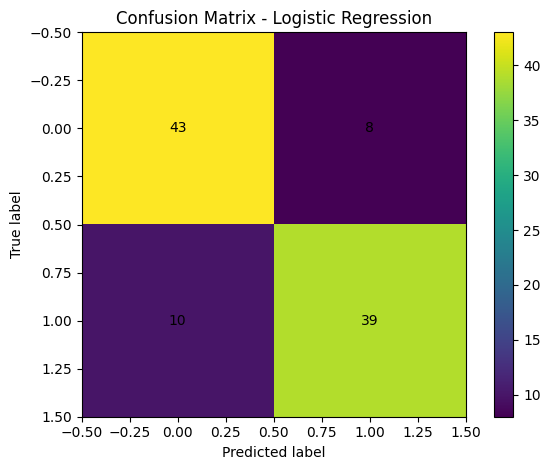

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=1000, random_state=42))
])

log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_lr,
    title="Confusion Matrix - Logistic Regression"
)


- KNN

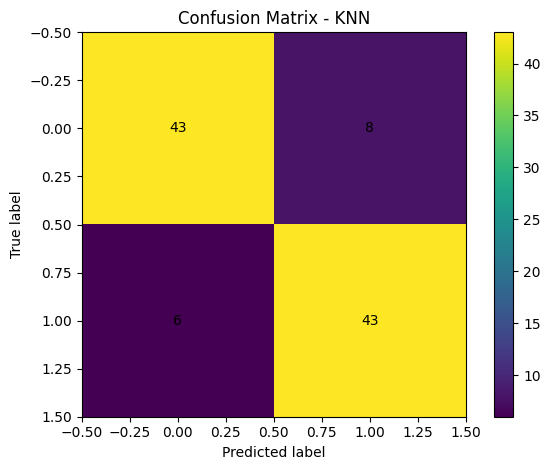

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", KNeighborsClassifier(
        n_neighbors=7,
        weights="distance"
    ))
])

knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_knn,
    title="Confusion Matrix - KNN"
)


- SVM (RBF 커널)

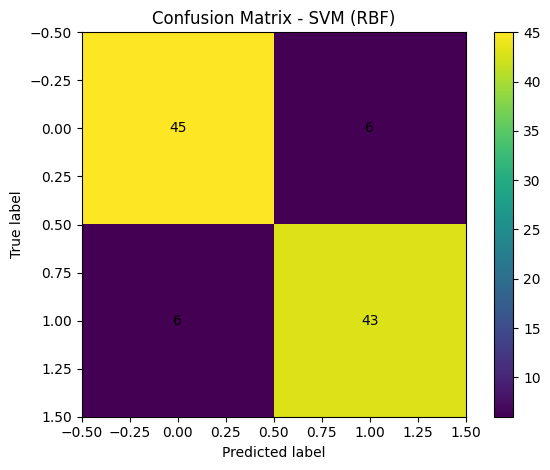

In [20]:
from sklearn.svm import SVC

svm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

plot_confusion_matrix(
    y_test,
    y_pred_svm,
    title="Confusion Matrix - SVM (RBF)"
)
